In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, make_scorer, fbeta_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

In [2]:
#preprocess data: Outlier,log
from sklearn.feature_selection import VarianceThreshold
from sklearn.base import BaseEstimator, TransformerMixin

class OutlierCapper(BaseEstimator, TransformerMixin):
    def __init__(self, lower_percentile=1, upper_percentile=99):
        self.lower_percentile = lower_percentile
        self.upper_percentile = upper_percentile

    def fit(self, X, y=None):
        self.lower_bounds = np.percentile(X, self.lower_percentile, axis=0)
        self.upper_bounds = np.percentile(X, self.upper_percentile, axis=0)
        return self

    def transform(self, X):
        return np.clip(X, self.lower_bounds, self.upper_bounds)
        
def preprocess_and_split_data():
    """
    Load the dataset, apply log transformation to specified columns, handle outliers,
    remove zero-variance features, and combine the target variable back.

    Returns:
    tuple: (X, y) where X is the feature DataFrame and y is the target Series.
    """
    # Load the dataset (fixed path)
    data = pd.read_csv('E:\coursentu\MH6805ml\project\data.csv')

    # Remove leading and trailing whitespace from column names
    data.columns = data.columns.str.strip()

    # Define the columns to be log-transformed and the target variable
    log_transform_columns = [
        'Cash Turnover Rate',
        'Quick Asset Turnover Rate',
        'Inventory Turnover Rate (times)',
        'Total Asset Growth Rate',
        'Research and development expense rate'
    ]
    target_variable = 'Bankrupt?'

    # Extract the target variable before further processing
    y = data[target_variable]
    X = data.drop(columns=[target_variable])

    # Apply log transformation to specified columns
    for column in log_transform_columns:
        if column in X.columns:  # Check if the column is in X
            # Apply log transformation: if value is greater than 0, apply log, otherwise keep it as 0
            X[column] = np.where(X[column] > 0, np.log(X[column]), 0)
    print(f"Applied log transformation to columns: {log_transform_columns}")

    # Filter out rows where any of the non-log-transformed columns have values >1 or <0
    non_log_columns = [col for col in X.columns if col not in log_transform_columns]
    condition = X[non_log_columns].apply(lambda row: ((row <= 1) & (row >= 0)).all(), axis=1)
    X = X[condition].reset_index(drop=True)
    y = y[condition].reset_index(drop=True)
    print("Filtered out rows with values >1 or <0 in non-log-transformed columns.")

    # Handle outliers using OutlierCapper
    outlier_capper = OutlierCapper(lower_percentile=1, upper_percentile=99)
    outlier_capper.fit(X)
    X = outlier_capper.transform(X)
    print("Capped outliers in the data.")

    # Combine processed features with the target variable
    processed_data = pd.concat([X, y], axis=1)
    print(f"Combined processed features with target variable. Final data shape: {processed_data.shape}")

    # Save the transformed data to a new CSV file
    processed_data.to_csv('E:\coursentu\MH6805ml\project\data_transformed2.csv', index=False)
    print("Saved the transformed data to 'data_transformed2.csv'.")

    return X, y

if __name__ == '__main__':
    X, y = preprocess_and_split_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=42)

<>:27: SyntaxWarning: invalid escape sequence '\c'
<>:71: SyntaxWarning: invalid escape sequence '\c'
<>:27: SyntaxWarning: invalid escape sequence '\c'
<>:71: SyntaxWarning: invalid escape sequence '\c'
C:\Users\DELL\AppData\Local\Temp\ipykernel_13564\3462248716.py:27: SyntaxWarning: invalid escape sequence '\c'
  data = pd.read_csv('E:\coursentu\MH6805ml\project\data.csv')
C:\Users\DELL\AppData\Local\Temp\ipykernel_13564\3462248716.py:71: SyntaxWarning: invalid escape sequence '\c'
  processed_data.to_csv('E:\coursentu\MH6805ml\project\data_transformed2.csv', index=False)
D:\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Applied log transformation to columns: ['Cash Turnover Rate', 'Quick Asset Turnover Rate', 'Inventory Turnover Rate (times)', 'Total Asset Growth Rate', 'Research and development expense rate']
Filtered out rows with values >1 or <0 in non-log-transformed columns.
Capped outliers in the data.
Combined processed features with target variable. Final data shape: (2920, 96)
Saved the transformed data to 'data_transformed2.csv'.


**Sampling Compare for RandomForest**

In [9]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, fbeta_score, balanced_accuracy_score
import pandas as pd

# Define the techniques to evaluate
oversampling_methods = [SMOTE(sampling_strategy=0.5), ADASYN(sampling_strategy=0.5)]
undersampling_methods = [RandomUnderSampler(sampling_strategy=0.8), EditedNearestNeighbours()]

# Define the F2 scorer
balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)

# Evaluate each combination
results = []
for over in oversampling_methods:
    for under in undersampling_methods:
        steps = [
            ('over', over),
            ('under', under),
            ('classifier', RandomForestClassifier(random_state=42))  # Add the classifier here
        ]
        pipeline = Pipeline(steps=steps)
        
        # Apply the pipeline to the training data and evaluate the model using cross-validation
        balanced_accuracy_scores = cross_val_score(pipeline, X_train, y_train, scoring=balanced_accuracy_scorer, cv=5)
        
        results.append({
            'oversampler': over.__class__.__name__,
            'undersampler': under.__class__.__name__,
            'mean_balanced_accuracy': balanced_accuracy_scores.mean()            
        })

# Convert results to a DataFrame for easy comparison
results_sample_df = pd.DataFrame(results)

# Print results
print(results_sample_df)

  oversampler             undersampler  mean_balanced_accuracy
0       SMOTE       RandomUnderSampler                0.660828
1       SMOTE  EditedNearestNeighbours                0.663605
2      ADASYN       RandomUnderSampler                0.661231
3      ADASYN  EditedNearestNeighbours                0.654985


Best Technique would be SMOTE+EditedNearestNeighbours

**Feature Selection with PCA**

In [12]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
import numpy as np
import pandas as pd

def apply_pca(X, variance_threshold=0.90):
    # Remove constant columns
    selector = VarianceThreshold(threshold=0.0)
    X_filtered = selector.fit_transform(X)
    pca = PCA(n_components=variance_threshold)
    X_pca = pca.fit_transform(X_filtered)  
    
    return X_pca, pca  

def get_pca_feature_importance(pca, initial_feature_names):
    n_pcs = pca.components_.shape[0]
    most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
    most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
    explained_variance = pca.explained_variance_ratio_
    
    dic = {
        'PC{}'.format(i + 1): {
            'Most Important Feature': most_important_names[i],
            'Explained Variance': explained_variance[i]
        } for i in range(n_pcs)
    }
    
    df = pd.DataFrame(dic).T  
    return df

if __name__ == '__main__':
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    # Apply SMOTE followed by Edited Nearest Neighbours
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    enn = EditedNearestNeighbours()
    X_train_balanced, y_train_balanced = enn.fit_resample(X_train_smote, y_train_smote)

    # Scale the balanced training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_test_scaled = scaler.transform(X_test)
    
    # Apply PCA on the training data
    X_train_pca, pca = apply_pca(X_train_scaled)
    
    # Transform the test data using the fitted PCA model
    X_test_filtered = VarianceThreshold(threshold=0.0).fit(X_train_scaled).transform(X_test_scaled)
    X_test_pca = pca.transform(X_test_filtered)

    # RandomForestClassifier
    model = RandomForestClassifier(random_state=42)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_pca, y_train_balanced, cv=5, scoring='balanced_accuracy')
    print('Cross-validated balanced accuracy scores:', cv_scores)
    print('Mean balanced accuracy:', cv_scores.mean())

    # Evaluation with
    model.fit(X_train_pca, y_train_balanced)
    y_pred = model.predict(X_test_pca)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    print('Test Balanced Accuracy:', balanced_acc)

    # Get the initial feature names after preprocessing
    feature_names_after_scaler = X.columns.tolist()  # Original feature names

    # Get PCA feature importance
    pca_feature_importance_df = get_pca_feature_importance(pca, feature_names_after_scaler)

    print(pca_feature_importance_df)
    number_of_components = pca.n_components_
    print('Number of components:', number_of_components)

    PCs = ['PC{}'.format(i + 1) for i in range(number_of_components)]
    components_df = pd.DataFrame(pca.components_)
    components_df = components_df.T
    components_df.columns = PCs
    print(components_df.head(5))


Cross-validated balanced accuracy scores: [0.98577681 0.98905908 0.98576225 0.98795043 0.9923268 ]
Mean balanced accuracy: 0.9881750741119903
Test Balanced Accuracy: 0.7228883200862185
                       Most Important Feature Explained Variance
PC1   Persistent EPS in the Last Four Seasons           0.324732
PC2                             Current Ratio           0.107319
PC3               Current Asset Turnover Rate           0.065718
PC4                      Total Asset Turnover             0.0605
PC5                 Cash Flow to Total Assets           0.045535
PC6                    Operating Gross Margin           0.033779
PC7                       Cash Flow to Equity           0.030797
PC8                 Quick Asset Turnover Rate           0.029675
PC9             Current Liabilities/Liability            0.02785
PC10       Degree of Financial Leverage (DFL)           0.023851
PC11         After-tax Net Profit Growth Rate           0.020054
PC12                   Cash/Current

Balanced accuracy increases 6%

**Bayesian Optimization**
  
Bayesian optimization uses probability to find the minimum of a function. The final aim is to find the input value to a function which can gives us the lowest possible output value.It usually performs better than random,grid and manual search providing better performance in the testing phase and reduced optimization time. In Hyperopt, Bayesian Optimization can be implemented giving 3 three main parameters to the function fmin.

Objective Function = defines the loss function to minimize.
Domain Space = defines the range of input values to test (in Bayesian Optimization this space creates a probability distribution for each of the used Hyperparameters).
Optimization Algorithm = defines the search algorithm to use to select the best input values to use in each new iteration.

In [30]:
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
from sklearn.datasets import make_classification

space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.choice('max_depth', range(10, 1200, 10)),
        'max_features': hp.choice('max_features', ['sqrt','log2', None]),
        'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50, 300, 750, 1200,1300,1500])
    }

def objective(space):
    model = RandomForestClassifier(criterion = space['criterion'], max_depth = space['max_depth'],
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'], 
                                 )
    
    accuracy = cross_val_score(model, X_train, y_train, cv = 5).mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }

if __name__ == '__main__':
    trials = Trials()
    best = fmin(fn= objective,
                space= space,
                algo= tpe.suggest,
                max_evals = 80,
                trials= trials)

    crit = {0: 'entropy', 1: 'gini'}
    feat = {0: 'sqrt', 1: 'log2', 2: None}
    est = {0: 10, 1: 50, 2: 300, 3: 750, 4: 1200,5:1300,6:1500}
    print(crit[best['criterion']])
    print(feat[best['max_features']])
    print(est[best['n_estimators']])

    model = RandomForestClassifier(criterion = crit[best['criterion']], max_depth = best['max_depth'], 
                                       max_features = feat[best['max_features']], 
                                       min_samples_leaf = best['min_samples_leaf'], 
                                       min_samples_split = best['min_samples_split'], 
                                       n_estimators = est[best['n_estimators']]).fit(X_train_pca, y_train_balanced)
    y_pred = model.predict(X_test_pca)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    print('Test Balanced Accuracy:', balanced_acc)

100%|█████████████████████████████████████████████| 80/80 [1:00:17<00:00, 45.22s/trial, best loss: -0.9781685243141345]
entropy
None
10
Test Balanced Accuracy: 0.8976155193318065


In [66]:
print('criterion：',crit[best['criterion']])
print('max_depth：',best['max_depth'])
print('max_features：',feat[best['max_features']])
print('min_samples_leaf：',best['min_samples_leaf'])
print('min_samples_split：',best['min_samples_split'])
print('n_estimators：',est[best['n_estimators']])

criterion： entropy
max_depth： 5
max_features： None
min_samples_leaf： 0.14178808464739434
min_samples_split： 0.20246315200981757
n_estimators： 10


In [71]:
conf_matrix_pca = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix_pca)
print('Test Balanced Accuracy:', balanced_acc)

Confusion Matrix:
[[499  72]
 [  1  12]]
Test Balanced Accuracy: 0.8984911760743635


In [73]:
model_nopca = RandomForestClassifier(criterion = crit[best['criterion']], max_depth = best['max_depth'], 
                                       max_features = feat[best['max_features']], 
                                       min_samples_leaf = best['min_samples_leaf'], 
                                       min_samples_split = best['min_samples_split'], 
                                       n_estimators = est[best['n_estimators']]).fit(X_train_scaled, y_train_balanced)
y_pred_nopca = model_nopca.predict(X_test_scaled)
balanced_acc_nopca = balanced_accuracy_score(y_test, y_pred_nopca)
conf_matrix_nopca = confusion_matrix(y_test, y_pred_nopca)
print('Confusion Matrix:')
print(conf_matrix_nopca)
print('Test Balanced Accuracy:', balanced_acc_nopca)

Confusion Matrix:
[[477  94]
 [  2  11]]
Test Balanced Accuracy: 0.8407651892765728


With Bayesian Optimization, balanced accuracy increases 17%. Compared with no pca, balanced accuracy increases 5%.

**ANN**

Epoch 1/10


D:\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - balanced_accuracy: 0.7552 - loss: 1.3181 - val_balanced_accuracy: 0.6095 - val_loss: 0.2139 - learning_rate: 0.0010
Epoch 2/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - balanced_accuracy: 0.9124 - loss: 0.1353 - val_balanced_accuracy: 0.6144 - val_loss: 0.0288 - learning_rate: 0.0010
Epoch 3/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - balanced_accuracy: 0.9148 - loss: 0.0235 - val_balanced_accuracy: 0.6092 - val_loss: 0.0178 - learning_rate: 0.0010
Epoch 4/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - balanced_accuracy: 0.9226 - loss: 0.0164 - val_balanced_accuracy: 0.6185 - val_loss: 0.0155 - learning_rate: 0.0010
Epoch 5/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - balanced_accuracy: 0.9270 - loss: 0.0160 - val_balanced_accuracy: 0.6058 - val_loss: 0.0189 - learning_rate: 0.0010
Epoch 6/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - balanced_accuracy: 0.9295 - loss: 0.0158 - val_balanced_accuracy: 0.6169 - val_loss: 0.0176 - learning_rat

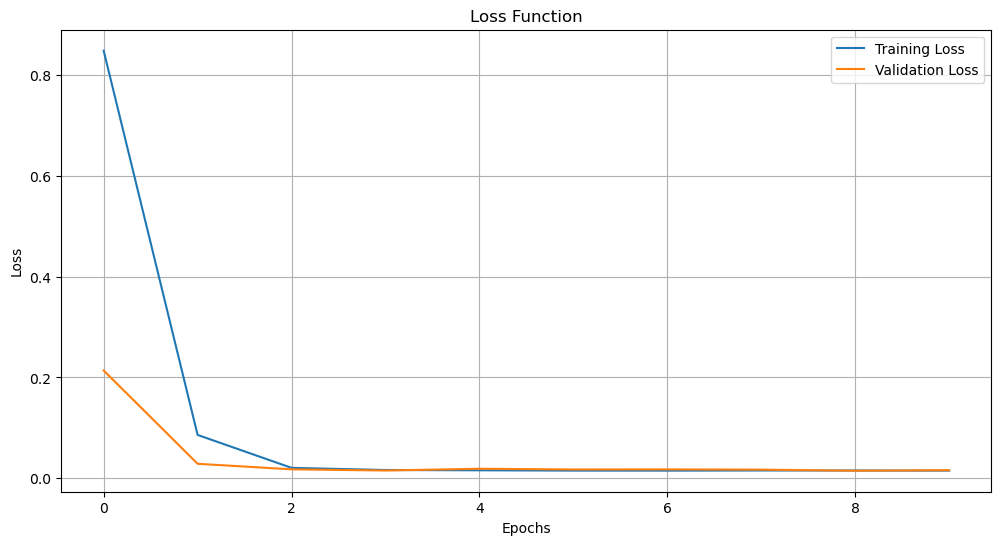

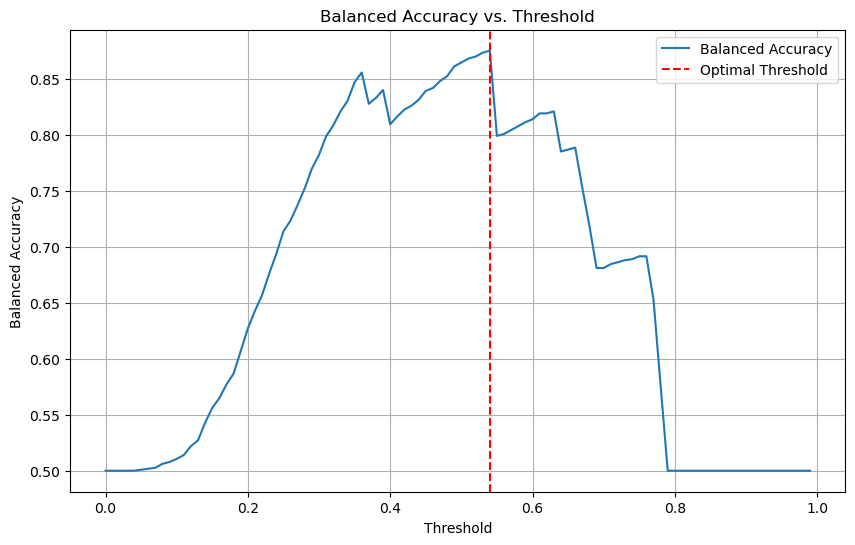

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers

# Define Focal Loss
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        weight = alpha * y_true * tf.pow(1 - y_pred, gamma) + (1 - alpha) * (1 - y_true) * tf.pow(y_pred, gamma)
        focal_loss_value = weight * cross_entropy
        return tf.reduce_mean(focal_loss_value)
    return focal_loss_fixed

# Define a custom balanced accuracy metric
def balanced_accuracy(y_true, y_pred):
    y_pred_classes = tf.cast(y_pred > 0.5, tf.int32)
    y_true = tf.cast(y_true, tf.int32)

    tp = tf.reduce_sum(tf.cast(y_true * y_pred_classes, tf.float32))
    tn = tf.reduce_sum(tf.cast((1 - y_true) * (1 - y_pred_classes), tf.float32))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred_classes, tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred_classes), tf.float32))

    sensitivity = tp / (tp + fn + tf.keras.backend.epsilon())
    specificity = tn / (tn + fp + tf.keras.backend.epsilon())

    balanced_acc = (sensitivity + specificity) / 2
    return balanced_acc

smote = SMOTE()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)
X_sm, y_sm = smote.fit_resample(X_train, y_train)

enn = EditedNearestNeighbours()
X_train_ann, y_train_ann = enn.fit_resample(X_sm, y_sm)

# Class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_ann), y=y_train_ann)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

scaler = StandardScaler()
X_train_ann = scaler.fit_transform(X_train_ann)
X_test = scaler.transform(X_test)

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch > 10:
        lr = lr * 0.9
    return lr

lr_scheduler = LearningRateScheduler(scheduler)

# Define the model
model_ann_nopca = keras.Sequential([
    keras.layers.Dense(75, activation='relu', input_shape=[X_train_ann.shape[1]], kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    keras.layers.Dense(190, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

model_ann_nopca.compile(optimizer='adam', metrics=[balanced_accuracy], loss=focal_loss(3, 0.75))

history_ann_nopca = model_ann_nopca.fit(X_train_ann, y_train_ann, epochs=10, validation_data=(X_test, y_test),
                                         verbose=1, batch_size=32, callbacks=[early_stop, lr_scheduler])

loss_ann_nopca, accuracy_ann_nopca = model_ann_nopca.evaluate(X_test, y_test)
print(f'Test Loss: {loss_ann_nopca:.4f}, Test Accuracy: {accuracy_ann_nopca:.4f}')

y_pred_ann_nopca = model_ann_nopca.predict(X_test).flatten()

thresholds = np.arange(0.0, 1.0, 0.01)
balanced_accuracies = []

for threshold in thresholds:
    y_pred_classes = (y_pred_ann_nopca > threshold).astype(int)
    balanced_acc = balanced_accuracy_score(y_test, y_pred_classes)
    balanced_accuracies.append(balanced_acc)

optimal_idx = np.argmax(balanced_accuracies)
optimal_threshold = thresholds[optimal_idx]
max_balanced_accuracy = balanced_accuracies[optimal_idx]

print(f'Optimal Threshold: {optimal_threshold:.2f}, Max Balanced Accuracy: {max_balanced_accuracy:.4f}')

# Use the optimal threshold for final predictions
y_pred_classes_optimal = (y_pred_ann_nopca > optimal_threshold).astype(int)

# Final evaluation
final_balanced_accuracy = balanced_accuracy_score(y_test, y_pred_classes_optimal)
final_conf_matrix = confusion_matrix(y_test, y_pred_classes_optimal)

print(f'Final Test Balanced Accuracy: {final_balanced_accuracy:.4f}')
print('Final Confusion Matrix:')
print(final_conf_matrix)

# Plotting the loss
plt.figure(figsize=(12, 6))
plt.plot(history_ann_nopca.history['loss'], label='Training Loss')
plt.plot(history_ann_nopca.history['val_loss'], label='Validation Loss')
plt.title('Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plotting balanced accuracy vs. threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, balanced_accuracies, label='Balanced Accuracy')
plt.axvline(optimal_threshold, color='red', linestyle='--', label='Optimal Threshold')
plt.title('Balanced Accuracy vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Balanced Accuracy')
plt.legend()
plt.grid()
plt.show()


**ANN with PCA**

In [7]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
import numpy as np
import pandas as pd

def apply_pca(X, variance_threshold=0.90):
    # Remove constant columns
    selector = VarianceThreshold(threshold=0.0)
    X_filtered = selector.fit_transform(X)
    pca = PCA(n_components=variance_threshold)
    X_pca = pca.fit_transform(X_filtered)  
    
    return X_pca, pca  

def get_pca_feature_importance(pca, initial_feature_names):
    n_pcs = pca.components_.shape[0]
    most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
    most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
    explained_variance = pca.explained_variance_ratio_
    
    dic = {
        'PC{}'.format(i + 1): {
            'Most Important Feature': most_important_names[i],
            'Explained Variance': explained_variance[i]
        } for i in range(n_pcs)
    }
    
    df = pd.DataFrame(dic).T  
    return df

if __name__ == '__main__':
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    # Apply SMOTE followed by Edited Nearest Neighbours
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    enn = EditedNearestNeighbours()
    X_train_balanced, y_train_balanced = enn.fit_resample(X_train_smote, y_train_smote)

    # Scale the balanced training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_test_scaled = scaler.transform(X_test)
    
    # Apply PCA on the training data
    X_train_pca, pca = apply_pca(X_train_scaled)
    
    # Transform the test data using the fitted PCA model
    X_test_filtered = VarianceThreshold(threshold=0.0).fit(X_train_scaled).transform(X_test_scaled)
    X_test_pca = pca.transform(X_test_filtered)

    # RandomForestClassifier
    model = RandomForestClassifier(random_state=42)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_pca, y_train_balanced, cv=5, scoring='balanced_accuracy')
    print('Cross-validated balanced accuracy scores:', cv_scores)
    print('Mean balanced accuracy:', cv_scores.mean())

    # Evaluation with
    model.fit(X_train_pca, y_train_balanced)
    y_pred = model.predict(X_test_pca)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    print('Test Balanced Accuracy:', balanced_acc)

    # Get the initial feature names after preprocessing
    feature_names_after_scaler = X.columns.tolist()  # Original feature names

    # Get PCA feature importance
    pca_feature_importance_df = get_pca_feature_importance(pca, feature_names_after_scaler)

    print(pca_feature_importance_df)
    number_of_components = pca.n_components_
    print('Number of components:', number_of_components)

    PCs = ['PC{}'.format(i + 1) for i in range(number_of_components)]
    components_df = pd.DataFrame(pca.components_)
    components_df = components_df.T
    components_df.columns = PCs
    print(components_df.head(5))

Cross-validated balanced accuracy scores: [0.98577681 0.98905908 0.98576225 0.98795043 0.9923268 ]
Mean balanced accuracy: 0.9881750741119903
Test Balanced Accuracy: 0.7228883200862185
                       Most Important Feature Explained Variance
PC1   Persistent EPS in the Last Four Seasons           0.324732
PC2                             Current Ratio           0.107319
PC3               Current Asset Turnover Rate           0.065718
PC4                      Total Asset Turnover             0.0605
PC5                 Cash Flow to Total Assets           0.045535
PC6                    Operating Gross Margin           0.033779
PC7                       Cash Flow to Equity           0.030797
PC8                 Quick Asset Turnover Rate           0.029675
PC9            Current Liability to Liability            0.02785
PC10       Degree of Financial Leverage (DFL)           0.023851
PC11         After-tax Net Profit Growth Rate           0.020054
PC12                   Cash/Current

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers

#X_train_pca, y_train_balanced,X_test_pca,y_test
# Class weights
class_weights_pca = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_balanced), y=y_train_balanced)
class_weights_dict_pca = {0: class_weights[0], 1: class_weights[1]}

# Define the model
model_ann_pca = keras.Sequential([
    keras.layers.Dense(75, activation='relu', input_shape=[X_train_ann.shape[1]], kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    keras.layers.Dense(190, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

model_ann_pca.compile(optimizer='adam', metrics=[balanced_accuracy], loss=focal_loss(3, 0.75))

history_ann_pca = model_ann_pca.fit(X_train_pca, y_train_balanced, epochs=10, validation_data=(X_test_pca, y_test),
                                         verbose=1, batch_size=32, callbacks=[early_stop, lr_scheduler])

loss_ann_pca, accuracy_ann_pca = model_ann_pca.evaluate(X_test_pca, y_test)
print(f'Test Loss: {loss_ann_pca:.4f}, Test Accuracy: {accuracy_ann_pca:.4f}')

y_pred_ann_pca = model_ann_pca.predict(X_test_pca).flatten()

thresholds = np.arange(0.0, 1.0, 0.01)
balanced_accuracies_ann_pca = []

for threshold in thresholds:
    y_pred_classes_pca = (y_pred_ann_pca > threshold).astype(int)
    balanced_acc_ann_pca = balanced_accuracy_score(y_test, y_pred_classes_pca)
    balanced_accuracies_ann_pca.append(balanced_acc_ann_pca)

optimal_idx_pca = np.argmax(balanced_accuracies_ann_pca)
optimal_threshold_pca = thresholds[optimal_idx_pca]
max_balanced_accuracy_pca = balanced_accuracies_ann_pca[optimal_idx_pca]

print(f'Optimal Threshold: {optimal_threshold_pca:.2f}, Max Balanced Accuracy: {max_balanced_accuracy_pca:.4f}')

# Use the optimal threshold for final predictions
y_pred_classes_optimal_pca = (y_pred_ann_pca > optimal_threshold_pca).astype(int)

# Final evaluation
final_balanced_accuracy_pca = balanced_accuracy_score(y_test, y_pred_classes_optimal_pca)
final_conf_matrix_pca = confusion_matrix(y_test, y_pred_classes_optimal_pca)

print(f'Final Test Balanced Accuracy: {final_balanced_accuracy_pca:.4f}')
print('Final Confusion Matrix:')
print(final_conf_matrix_pca)

# Plotting the loss
plt.figure(figsize=(12, 6))
plt.plot(history_ann_pca.history['loss'], label='Training Loss')
plt.plot(history_ann_pca.history['val_loss'], label='Validation Loss')
plt.title('Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plotting balanced accuracy vs. threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, balanced_accuracies_ann_pca, label='Balanced Accuracy')
plt.axvline(optimal_threshold_pca, color='red', linestyle='--', label='Optimal Threshold')
plt.title('Balanced Accuracy vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Balanced Accuracy')
plt.legend()
plt.grid()
plt.show()


Epoch 1/10


D:\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_6" is incompatible with the layer: expected axis -1 of input shape to have value 95, but received input with shape (None, 23)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 23), dtype=float32)
  • training=True
  • mask=None